In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import random
from timeit import default_timer as timer

In [2]:
def train_test_split(df, test_size):
    '''splits the data into training and testing sets based on size of requested test set'''

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population = indices, k = test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

In [133]:
'''
https://lethalbrains.com/learn-ml-algorithms-by-coding-decision-trees-439ac503c9a4
https://medium.com/@curiousily/building-a-decision-tree-from-scratch-in-python-machine-learning-from-scratch-part-ii-6e2e56265b19
https://towardsdatascience.com/random-forests-and-decision-trees-from-scratch-in-python-3e4fa5ae4249
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
'''

class AB_DecisionTree:

    def __init__(self, max_depth = 5, min_leaf_opens = 1000, min_leaf_clicks = 10, max_p_value = 0.1):
        self.max_depth = max_depth
        self.min_leaf_opens = min_leaf_opens
        self.min_leaf_clicks = min_leaf_clicks
        self.max_p_value = max_p_value

    def fit(self, data, click_column_name = 'click', option_column_name = 'option'):
        self.tree = Node(data, click_column_name = click_column_name, option_column_name = option_column_name, depth = 0, max_depth = self.max_depth, min_leaf_opens = self.min_leaf_opens, min_leaf_clicks = self.min_leaf_clicks, max_p_value = self.max_p_value)
        return self

    def predict(self, X, pred_type = 'class'):
        return self.tree.predict(X, pred_type)
    
    def get_json(self):
        return self.tree.get_json()

class Node:
    tree_nodes = 0
    def __init__(self, data, click_column_name, option_column_name, depth = 0, max_depth = 6, min_leaf_opens = 1000, min_leaf_clicks = 10, max_p_value = 0.05):
        self.node_id = Node.tree_nodes
        self.depth = depth
        Node.tree_nodes += 1
        self.max_depth = max_depth
        self.min_leaf_opens = min_leaf_opens
        self.min_leaf_clicks = min_leaf_clicks
        self.max_p_value = max_p_value

        self.data = data
        self.click_column_name = click_column_name
        self.option_column_name = option_column_name
        self.available_options = self.data[self.option_column_name].unique()
        self.independent_variable_names = [x for x in data.columns if x not in [click_column_name, option_column_name]]
        self.feature_types_dict = self.get_feature_types_dict()
        self.choice, self.incremental_clicks, self.p_value, self.pivot = self.get_node_info()
        self.split_column = None
        self.split_value = None
        self.split_operator = None
        self.split_incremental_clicks = None
        self.left = None
        self.right = None

        self.find_split()

    def find_split(self):
        '''Searches for a split and creates branches if a split is found'''
        if self.depth < self.max_depth:
            self.split_column, self.split_value, self.split_incremental_clicks = self.find_best_variable_split()

            if self.split_column is not None:
                self.split_column_feature_type = self.feature_types_dict[self.split_column]
                self.create_branches()
        else:
            self.data = None
            return

    def create_branches(self):
        '''Splits data based on split found and initializes Left and Right Nodes'''
        data_left, data_right = self.split_data()
        
        self.data = None
        
        self.left = Node(data_left, click_column_name = self.click_column_name, option_column_name = self.option_column_name, depth = self.depth + 1, max_depth = self.max_depth, min_leaf_opens = self.min_leaf_opens, min_leaf_clicks = self.min_leaf_clicks, max_p_value = self.max_p_value)
        self.right = Node(data_right, click_column_name = self.click_column_name, option_column_name = self.option_column_name, depth = self.depth + 1, max_depth = self.max_depth, min_leaf_opens = self.min_leaf_opens, min_leaf_clicks = self.min_leaf_clicks, max_p_value = self.max_p_value)

        data_left, data_right = None, None

    def get_feature_types_dict(self):
        '''Generates a dictionary of feature and feature types'''
        feature_type_dict = {}
        n_unique_values_threshold = 15

        for column in self.data.columns:
            unique_values = self.data[column].unique()
            if np.array_equal(unique_values, [0,1]) or np.array_equal(unique_values, [1,0]) or np.array_equal(unique_values, [1]) or np.array_equal(unique_values, [0]):
                feature_type_dict[column] = 'binomial'
            elif isinstance(unique_values[0], str):# or (len(unique_values) <= n_unique_values_threshold):
                feature_type_dict[column] = 'categorical'
            else:
                feature_type_dict[column] = 'continuous'

        return feature_type_dict

    def get_node_info(self):
        '''Pivots data and extracts information from it'''
        pivot = self.data.groupby([self.option_column_name])[self.click_column_name].agg({'opens': 'count', 'clicks': 'sum', 'mean':'mean'})
        sims = pivot.apply(lambda x: [np.random.beta(1 + x['clicks'],1+x['opens']) for i in range(1000)], axis=1)
        pivot['prob_of_choice'] = pd.DataFrame(list(zip(*(sims.tolist()))), columns = sims.index).idxmax(axis = 1, skipna = True).value_counts()/1000
        pivot = pivot.fillna(0)
        incremental_clicks = np.round((pivot['mean'].max() - self.data[self.click_column_name].mean()) * pivot['opens'].sum(),0)
        z,p_value = proportions_ztest(count=pivot['clicks'], nobs=pivot['opens'], value=0, alternative='two-sided')
        choice = pivot['mean'].argmax()
        pivot = pivot.to_dict(orient='index')

        return(choice, incremental_clicks, p_value, pivot)

    def calculate_incremental_clicks(self):
        '''Calculates Incremental Clicks
           (aka: how many more clicks would this node generate, if all users were shown the best option)'''
        pivot = self.data.groupby([self.option_column_name])[self.click_column_name].agg({'opens': 'count', 'clicks': 'sum', 'mean':'mean'})
        incremental_clicks = np.round((pivot['mean'].max() - self.data[self.click_column_name].mean()) * pivot['opens'].sum(),0)

        return incremental_clicks

    def find_best_value_split(self, feature):
        '''calls specific value search function for differnt types of features'''
        feature_type = self.feature_types_dict[feature]
        if feature_type == 'binomial':
            split_value, total_incremental_clicks = self.find_best_split_for_binary_variable(feature)
        elif feature_type == 'categorical':
            split_value, total_incremental_clicks = self.find_best_split_for_categorical_variable(feature)
        elif feature_type == 'continuous':
            split_value, total_incremental_clicks = self.find_best_split_for_continuous_variable(feature)

        return(split_value, total_incremental_clicks)

    def find_best_variable_split(self):
        '''Iterates through independent variables to find the one which can increase the over all incremental clicks'''
        best_variable = None
        best_split_value = None
        max_incremental_clicks = self.incremental_clicks

        for v in self.independent_variable_names:
            split_value, total_incremental_clicks = self.find_best_value_split(v)
            if split_value is None:
                pass
            elif total_incremental_clicks > max_incremental_clicks:
                best_split_value = split_value
                max_incremental_clicks = total_incremental_clicks
                best_variable = v

        return(best_variable, best_split_value, max_incremental_clicks)

    def split_data(self):
        '''splits data to be used in Left and Right Nodes
           spliting is differentiated by feature type'''
        if self.split_column_feature_type == 'continuous':
            self.split_operator = "<="
            data_left = self.data[self.data[self.split_column] <= self.split_value]
            data_right = self.data[self.data[self.split_column]  > self.split_value]
        else:
            self.split_operator = "=="
            data_left = self.data[self.data[self.split_column]  == self.split_value]
            data_right = self.data[self.data[self.split_column]  != self.split_value]
        return data_left, data_right

    def check_enough_data(self):
        '''verifies that a Node has enough data'''
        pivot = self.data.groupby([self.option_column_name])[self.click_column_name].agg({'opens': 'count', 'clicks': 'sum'})
        enough_data = np.all((pivot['opens']) > self.min_leaf_opens) & np.all(pivot['clicks'] > self.min_leaf_clicks)
        enough_options = len(pivot['opens']) > 1

        return enough_options & enough_data

    def find_best_split_for_categorical_variable(self, variable):
        '''searches for best value split based on p-value and incremental clicks
           optimized for categorical type variables'''

        pivot = self.data.groupby([self.option_column_name,variable])[self.click_column_name].agg({'opens': 'count', 'clicks': 'sum'}).unstack(self.option_column_name)
        pivot = pivot.fillna(0)
        pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
        pivot.reset_index(inplace=True)

        for x in self.available_options:

            pivot['{}_opens_equal'.format(x)] = pivot['opens_{}'.format(x)]
            pivot['{}_opens_not_equal'.format(x)] = pivot['opens_{}'.format(x)].sum() - pivot['{}_opens_equal'.format(x)]

            pivot['{}_clicks_equal'.format(x)] = pivot['clicks_{}'.format(x)]
            pivot['{}_clicks_not_equal'.format(x)] = pivot['clicks_{}'.format(x)].sum() - pivot['{}_clicks_equal'.format(x)]

            pivot['{}_ctr_equal'.format(x)] = pivot['{}_clicks_equal'.format(x)] / pivot['{}_opens_equal'.format(x)]
            pivot['{}_ctr_not_equal'.format(x)] = pivot['{}_clicks_not_equal'.format(x)] / pivot['{}_opens_not_equal'.format(x)]

        pivot['can_use'] = np.all((pivot[[s for s in pivot.columns if "_opens_" in s]] >= 1000) , axis=1)
        pivot = pivot[pivot['can_use'] == True]
        if pivot.empty:
            return None, 0

        pivot['clicks_equal'] = pivot[[s for s in pivot.columns if "_clicks_equal" in s]].sum(axis=1)
        pivot['clicks_not_equal'] = pivot[[s for s in pivot.columns if "_clicks_not_equal" in s]].sum(axis=1)

        pivot['opens_equal'] = pivot[[s for s in pivot.columns if "_opens_equal" in s]].sum(axis=1)
        pivot['opens_not_equal'] = pivot[[s for s in pivot.columns if "_opens_not_equal" in s]].sum(axis=1)

        pivot['ctr_equal'] = pivot['clicks_equal'] / pivot['opens_equal']
        pivot['ctr_not_equal'] = pivot['clicks_not_equal'] / pivot['opens_not_equal']

        pivot['equal_incremental_clicks'] = (pivot[[s for s in pivot.columns if "_ctr_equal" in s]].max(axis=1) - pivot['ctr_equal']) * pivot['opens_equal']
        pivot['not_equal_incremental_clicks'] = (pivot[[s for s in pivot.columns if "_ctr_not_equal" in s]].max(axis=1) - pivot['ctr_not_equal']) * pivot['opens_not_equal']

        pivot['Total_Incremental_Clicks'] = pivot['equal_incremental_clicks'] + pivot['not_equal_incremental_clicks']

        pivot = pivot.nlargest(5, 'Total_Incremental_Clicks')
        pivot = pivot.drop_duplicates()

        pivot['p_value_equal'] = pivot.apply(lambda row: proportions_ztest(count=np.array(row[[s for s in pivot.columns if "_clicks_equal" in s]]), nobs=np.array(row[[s for s in pivot.columns if "_opens_equal" in s]]), value=0, alternative='two-sided')[1], axis=1)
        pivot['p_value_not_equal'] = pivot.apply(lambda row: proportions_ztest(count=np.array(row[[s for s in pivot.columns if "_clicks_not_equal" in s]]), nobs=np.array(row[[s for s in pivot.columns if "_opens_not_equal" in s]]), value=0, alternative='two-sided')[1], axis=1)
        pivot = pivot[(pivot['p_value_equal'] <= self.max_p_value) | (pivot['p_value_not_equal'] <= self.max_p_value)]
        if pivot.empty:
            return None, 0

        incremental_clicks = np.round(pivot['Total_Incremental_Clicks'].max(), 0)
        split_value = pivot.loc[pivot['Total_Incremental_Clicks'].idxmax(), variable]

        return split_value, incremental_clicks

    def find_best_split_for_binary_variable(self, variable):
        '''searches for best value split based on p-value and incremental clicks
           optimized for binary type variables'''
        pivot = self.data.groupby([self.option_column_name,variable])[self.click_column_name].agg({'opens': 'count', 'clicks': 'sum','mean':'mean'}).unstack(self.option_column_name)
        pivot = pivot.fillna(0)
        pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
        pivot.reset_index(inplace=True)

        pivot['can_use'] = np.all(np.all(pivot[[s for s in pivot.columns if "opens_" in s]] >= 1000, axis=1))
        pivot = pivot[pivot['can_use'] == True]
        
        if pivot.empty:
            return None, 0

        pivot['p_value'] = pivot.apply(lambda row: proportions_ztest(count=np.array(row[[s for s in pivot.columns if "clicks_" in s]]), nobs=np.array(row[[s for s in pivot.columns if "opens_" in s]]), value=0, alternative='two-sided')[1], axis=1)
        pivot = pivot[pivot['p_value'] <= self.max_p_value]
        if pivot.empty:
            return None, 0

        pivot['total_opens'] = pivot[[s for s in pivot.columns if "opens_" in s]].sum(axis=1)
        pivot['total_clicks'] = pivot[[s for s in pivot.columns if "clicks_" in s]].sum(axis=1)
        pivot['total_mean'] = pivot['total_clicks']/pivot['total_opens']
        pivot['total_incremental_clicks'] = (pivot[[s for s in pivot.columns if "mean_" in s]].max(axis=1) - pivot['total_mean']) * pivot['total_opens']
        total_incremental_clicks = np.round(pivot['total_incremental_clicks'].sum(),0)

        split_value = 1

        return split_value, total_incremental_clicks

    def find_best_split_for_continuous_variable(self, variable):
        '''searches for best value split based on p-value and incremental clicks
           optimized for continuous type variables'''

        pivot = self.data.groupby([self.option_column_name,variable])[self.click_column_name].agg({'opens': 'count', 'clicks': 'sum'}).unstack(self.option_column_name)
        pivot = pivot.fillna(0)
        pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
        pivot.reset_index(inplace=True)

        for x in self.available_options:

            pivot['{}_opens_below'.format(x)] = pivot['opens_{}'.format(x)].cumsum()
            pivot['{}_opens_above'.format(x)] = pivot['opens_{}'.format(x)].sum() - pivot['{}_opens_below'.format(x)]

            pivot['{}_clicks_below'.format(x)] = pivot['clicks_{}'.format(x)].cumsum()
            pivot['{}_clicks_above'.format(x)] = pivot['clicks_{}'.format(x)].sum() - pivot['{}_clicks_below'.format(x)]

            pivot['{}_ctr_below'.format(x)] = pivot['{}_clicks_below'.format(x)] / pivot['{}_opens_below'.format(x)]
            pivot['{}_ctr_above'.format(x)] = pivot['{}_clicks_above'.format(x)] / pivot['{}_opens_above'.format(x)]

        pivot['can_use'] = np.all((pivot[[s for s in pivot.columns if "_opens_" in s]] >= 1000) , axis=1)
        pivot = pivot[pivot['can_use'] == True]
    
        if pivot.empty:
            return None, 0

        pivot['clicks_below'] = pivot[[s for s in pivot.columns if "_clicks_below" in s]].sum(axis=1)
        pivot['clicks_above'] = pivot[[s for s in pivot.columns if "_clicks_above" in s]].sum(axis=1)

        pivot['opens_below'] = pivot[[s for s in pivot.columns if "_opens_below" in s]].sum(axis=1)
        pivot['opens_above'] = pivot[[s for s in pivot.columns if "_opens_above" in s]].sum(axis=1)

        pivot['ctr_below'] = pivot['clicks_below'] / pivot['opens_below']
        pivot['ctr_above'] = pivot['clicks_above'] / pivot['opens_above']

        pivot = pivot.fillna(0)

        pivot['Incremental_Clicks_Below'] = (pivot[[s for s in pivot.columns if "_ctr_below" in s]].max(axis=1) - pivot['ctr_below']) * pivot['opens_below']
        pivot['Incremental_Clicks_Above'] = (pivot[[s for s in pivot.columns if "_ctr_above" in s]].max(axis=1) - pivot['ctr_above']) * pivot['opens_above']

        pivot['Total_Incremental_Clicks'] = pivot['Incremental_Clicks_Below'] + pivot['Incremental_Clicks_Above']

        pivot = pivot.nlargest(5, 'Total_Incremental_Clicks')

        pivot['p_value_below'] = pivot.apply(lambda row: proportions_ztest(count=np.array(row[[s for s in pivot.columns if "_clicks_below" in s]]), nobs=np.array(row[[s for s in pivot.columns if "_opens_below" in s]]), value=0, alternative='two-sided')[1], axis=1)
        pivot['p_value_above'] = pivot.apply(lambda row: proportions_ztest(count=np.array(row[[s for s in pivot.columns if "_clicks_above" in s]]), nobs=np.array(row[[s for s in pivot.columns if "_opens_above" in s]]), value=0, alternative='two-sided')[1], axis=1)
        pivot = pivot[(pivot['p_value_below'] <= self.max_p_value) | (pivot['p_value_above'] <= self.max_p_value)]
        if pivot.empty:
            return None, 0

        incremental_clicks = np.round(pivot['Total_Incremental_Clicks'].max(),0)
        split_value = pivot.loc[pivot['Total_Incremental_Clicks'].idxmax(), variable]

        return split_value, incremental_clicks

    @property
    def is_leaf(self): return self.split_column is None

    def predict(self, X, pred_type):
        '''given a pandas DataFrame, will call predict_row on each row'''
        return X.apply(self.predict_row, axis = 1, args = (pred_type,))


    def predict_row(self, xi, pred_type):
        '''given a row from a pandas DataFrame, will either return the requested info or
           will pass row to next node based on the row's values and filter at each node'''
        if self.is_leaf:
            if pred_type == 'class':
                return self.choice
            elif pred_type == 'node':
                return self.node_id
            elif pred_type == 'p_value':
                return np.round(self.p_value, 5)
            elif pred_type == 'choice_probs':
                return dict(zip(self.pivot.keys(), [x['prob_of_choice'] for x in self.pivot.values()]))
        if self.split_operator == "<=":
            if xi[self.split_column] <= self.split_value:
                node = self.left  
            else:
                node = self.right
        else:
            if xi[self.split_column] == self.split_value:
                node = self.left  
            else:
                node = self.right
        return node.predict_row(xi, pred_type)
    
    def get_json(self):
        '''generates a dictionary format of the tree which can be formatted into a json'''
        if self.is_leaf:
            return {"node_id":self.node_id,"choice":self.choice, "incremental_clicks":self.incremental_clicks, "p_value":self.p_value, 'pivot':self.pivot}
        else:
            question = "{} {} {}".format(self.split_column, self.split_operator, self.split_value)
            json = {question:{'yes':self.left.get_json(),'no':self.right.get_json()}}
            
            return json


In [130]:
simulation_data = pd.read_csv('simulation_data.csv')
train_df, test_df = train_test_split(simulation_data, .2)

In [144]:
train_df = train_df.rename(columns = {"click":"reward"})
test_df = train_df.rename(columns = {"click":"reward"})

In [145]:
start = timer()
tree = AB_DecisionTree(max_depth = 5).fit(train_df, click_column_name = 'reward', option_column_name = 'choice')
end = timer()
print('{} Seconds'.format(np.round(end - start,3)))

64.868 Seconds


In [148]:
def policy_evaluation(tree, data):
    data_for_calc = data.copy()
    click_column = tree.tree.click_column_name
    option_column = tree.tree.option_column_name
    data_for_calc['pred_node'] = tree.predict(data_for_calc, pred_type = 'node')
    data_for_calc['pred_class'] = tree.predict(data_for_calc, pred_type = 'class')
    options = data_for_calc.pred_class.unique()
    data_for_calc['pred_p_value'] = tree.predict(data_for_calc, pred_type = 'p_value')

    choice_probs = tree.predict(data_for_calc, pred_type = 'choice_probs').apply(pd.Series)
    data_for_calc = pd.concat([data_for_calc, choice_probs], axis=1)
    
    pivot = data_for_calc.groupby([option_column,'pred_node'])[click_column].agg({'opens': 'count', 'clicks': 'sum', 'mean':'mean'}).unstack(option_column)
    pivot = pivot.fillna(0)
    pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
    pivot.reset_index(inplace=True)

    pivot_class = pd.DataFrame(data_for_calc.groupby(['pred_node']).pred_class.max())
    pivot_class.reset_index(inplace=True)

    pivot_p_value = pd.DataFrame(data_for_calc.groupby(['pred_node']).pred_p_value.max())
    pivot_p_value.reset_index(inplace=True)
    
    pivot_choice_probs = pd.DataFrame(data_for_calc.groupby(['pred_node'])[choice_probs.columns].max())
    pivot_choice_probs.columns = [str(col) + '_prob' for col in pivot_choice_probs.columns]
    pivot_choice_probs.reset_index(inplace=True)
    
    pivot = pivot.merge(pivot_class, left_on='pred_node', right_on='pred_node')
    pivot = pivot.merge(pivot_p_value, left_on='pred_node', right_on='pred_node')
    pivot = pivot.merge(pivot_choice_probs, left_on='pred_node', right_on='pred_node')
    
    pivot['pred_class'] = pivot['pred_class'].apply(lambda x: "mean_{}".format(x))
    #pivot['mean_of_choice'] = pivot.lookup(pivot.index, pivot['pred_class'])
    
    for option in options:
        pivot['{}_weight'.format(option)] = pivot['mean_{}'.format(option)] * pivot['{}_prob'.format(option)]
    
    pivot['mean_of_policy'] = pivot[[s for s in pivot.columns if "_weight" in s]].sum(axis=1)
    
    pivot['total_opens'] = pivot[[s for s in pivot.columns if "opens_" in s]].sum(axis=1)
    pivot['total_clicks'] = pivot[[s for s in pivot.columns if "clicks_" in s]].sum(axis=1)
    pivot['total_mean'] = pivot['total_clicks']/pivot['total_opens']
    #pivot['total_incremental_clicks'] = (pivot['mean_of_choice'] - pivot['total_mean']) * pivot['total_opens']
    pivot['total_incremental_clicks'] = (pivot['mean_of_policy'] - pivot['total_mean']) * pivot['total_opens']
    pivot['potential_incremental_clicks'] = (pivot[[s for s in pivot.columns if "mean_" in s]].max(axis=1) - pivot['total_mean']) * pivot['total_opens']
    total_incremental_clicks = np.round(pivot['total_incremental_clicks'].sum(),0)
    potential_incremental_clicks = np.round(pivot['potential_incremental_clicks'].sum(),0)

    actual_clicks = pivot.total_clicks.sum()
    actual_opens = pivot.total_opens.sum()
    actual_ctor = actual_clicks/actual_opens

    pred_clicks = actual_clicks + total_incremental_clicks
    pred_ctor = pred_clicks / actual_opens
    
    potential_clicks = actual_clicks + potential_incremental_clicks
    potential_ctor = potential_clicks / actual_opens

    pred_lift = (pred_ctor - actual_ctor)/actual_ctor
    potential_lift = (potential_ctor - actual_ctor)/actual_ctor
    
    print("Actual CTOR: {}%  Pred CTOR: {}%  Potential CTOR: {}%".format(np.round(actual_ctor*100,2), np.round(pred_ctor*100,2), np.round(potential_ctor*100,2)))
    print("Pred Lift: {}% Potential Lift {}%".format(np.round(pred_lift*100,2),np.round(potential_lift*100,2)))
    return(pred_lift, pivot)

In [149]:
pred_lift, pivot = policy_evaluation(tree, test_df)
pivot

Actual CTOR: 8.27%  Pred CTOR: 10.14%  Potential CTOR: 10.17%
Pred Lift: 22.65% Potential Lift 23.0%


,pred_node,opens_A,opens_B,clicks_A,clicks_B,mean_A,mean_B,pred_class,pred_p_value,A_prob,B_prob,B_weight,A_weight,mean_of_policy,total_opens,total_clicks,total_mean,total_incremental_clicks,potential_incremental_clicks
0,19,12036,12007,1272,582,0.105683,0.048472,mean_A,0.00000,1.000,0.000,0.000000,0.105683,0.105683,24043,1854,0.077112,686.935194,686.935194
1,20,8082,8058,783,813,0.096882,0.100894,mean_B,0.39330,0.203,0.797,0.080412,0.019667,0.100079,16140,1596,0.098885,19.277882,32.421445
2,24,1514,1570,174,133,0.114927,0.084713,mean_A,0.00508,0.994,0.006,0.000508,0.114238,0.114746,3084,307,0.099546,46.876852,47.435931
3,25,1051,1006,110,86,0.104662,0.085487,mean_A,0.13870,0.898,0.102,0.008720,0.093987,0.102706,2057,196,0.095284,15.266985,19.290200
4,26,1814,1763,164,188,0.090408,0.106636,mean_B,0.12377,0.081,0.919,0.097999,0.007323,0.105322,3577,352,0.098406,24.736467,29.438457
5,30,3017,3038,164,284,0.054359,0.093483,mean_B,0.00000,0.000,1.000,0.093483,0.000000,0.093483,6055,448,0.073988,118.036866,118.036866
6,31,1550,1509,96,166,0.061935,0.110007,mean_B,0.00000,0.000,1.000,0.110007,0.000000,0.110007,3059,262,0.085649,74.510272,74.510272
7,32,1312,1365,74,105,0.056402,0.076923,mean_B,0.03360,0.011,0.989,0.076077,0.000620,0.076697,2677,179,0.066866,26.318806,26.923077
8,33,9734,9574,476,947,0.048901,0.098914,mean_B,0.00000,0.000,1.000,0.098914,0.000000,0.098914,19308,1423,0.073700,486.826196,486.826196


In [113]:
train_lifts = []
test_lifts = []
training_times = []
for i in range(11):
    #print(i)
    start = timer()
    tree = AB_DecisionTree(max_depth = i).fit(train_df)
    end = timer()
    training_times.append(np.round(end - start,3))  
    #print('train')
    train_lift, pivot = policy_evaluation(tree, train_df)
    #print('test')
    test_lift, pivot = policy_evaluation(tree, test_df)
    train_lifts.append(train_lift)
    test_lifts.append(test_lift)

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

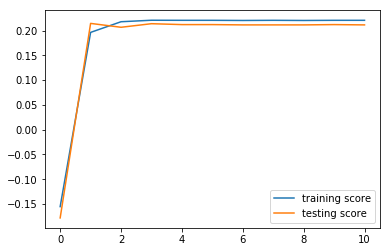

In [115]:
plt.plot(train_lifts, label = 'training score')
plt.plot(test_lifts, label = 'testing score')
plt.legend()

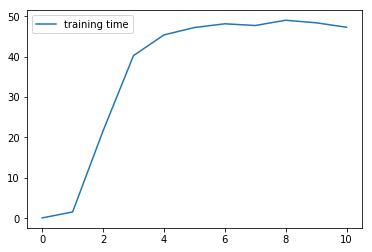

In [143]:
plt.plot(training_times, label = 'training time')
plt.legend()

In [146]:
json = tree.get_json()
print(json)

{'Gender == 1': {'yes': {'Device == Mobile': {'yes': {'node_id': 19, 'choice': 'A', 'incremental_clicks': 687.0, 'p_value': 4.4534035225273535e-62, 'pivot': {'A': {'opens': 12036.0, 'clicks': 1272.0, 'mean': 0.10568295114656032, 'prob_of_choice': 1.0}, 'B': {'opens': 12007.0, 'clicks': 582.0, 'mean': 0.04847172482718414, 'prob_of_choice': 0.0}}}, 'no': {'node_id': 20, 'choice': 'B', 'incremental_clicks': 32.0, 'p_value': 0.39329882226634316, 'pivot': {'A': {'opens': 8082.0, 'clicks': 783.0, 'mean': 0.09688195991091314, 'prob_of_choice': 0.203}, 'B': {'opens': 8058.0, 'clicks': 813.0, 'mean': 0.10089352196574833, 'prob_of_choice': 0.797}}}}}, 'no': {'Income <= 148028': {'yes': {'AgeGroup <= 3.0': {'yes': {'Income <= 107608': {'yes': {'node_id': 24, 'choice': 'A', 'incremental_clicks': 47.0, 'p_value': 0.0050835167997553945, 'pivot': {'A': {'opens': 1514.0, 'clicks': 174.0, 'mean': 0.11492734478203434, 'prob_of_choice': 0.994}, 'B': {'opens': 1570.0, 'clicks': 133.0, 'mean': 0.0847133757